# XGBoost Time Series Forecasting
https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [1]:
# ! pip3 install xgboost

## Dataset

[Dataset (daily-total-female-births.csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv)

[Description (daily-total-female-births.names)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.names)

## Model

In [2]:
from numpy import asarray

from pandas import read_csv, DataFrame, concat

from sklearn.metrics import mean_absolute_error

from xgboost import XGBRFRegressor

from matplotlib import pyplot

In [3]:
# Transform a time series dataset to a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # Input sequence (t-n ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # Forecast sequence (t, t+1 ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # Put it all together
    agg = concat(cols, axis=1)
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [4]:
# Split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [5]:
# Fit an XGBoost model and make a one step prediction
def xgboost_forecats(train, testX):
    # Transform list into array
    train = asarray(train)
    # Split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # Fit model
    model = XGBRFRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # Make a one step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [6]:
# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # Split dataset
    train, test = train_test_split(data, n_test)
    # Seed history with training dataset
    history = [x for x in train]
    # Step over each time step in the test set
    for i in range(len(test)):
        # Split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # Fit model on history and make a prediction
        yhat = xgboost_forecats(history, testX)
        # Store forecast in list of predictions
        predictions.append(yhat)
        # Add actual observation to history for the next loop
        history.append(test[i])
        # Summarize progress
        print(f'>expected={testy}, predicted={yhat}')
    # Estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [7]:
# Load the dataset
series = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', 
                  header=0, index_col=0)
values = series.values

In [8]:
# Transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [9]:
# Evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print(f'MAE: {mae}')

/home/vladiant/.local/lib/python3.8/site-packages/xgboost/data.py:104: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>expected=42.0, predicted=45.88021469116211
>expected=53.0, predicted=42.82456970214844
>expected=39.0, predicted=42.271217346191406
>expected=40.0, predicted=38.866722106933594
>expected=38.0, predicted=42.96770477294922
>expected=44.0, predicted=44.116111755371094
>expected=34.0, predicted=41.79288101196289
>expected=37.0, predicted=39.58625030517578
>expected=52.0, predicted=39.419639587402344
>expected=48.0, predicted=41.25883865356445
>expected=55.0, predicted=42.20597839355469
>expected=50.0, predicted=44.72806167602539
MAE: 5.9425474802653


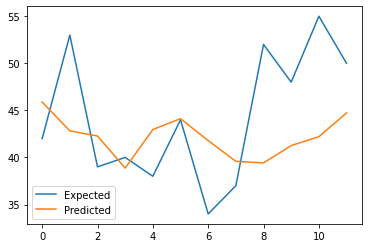

In [10]:
# Plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Predict a single value

In [11]:
# Transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)

In [12]:
# Split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]

In [13]:
# Fit model
model = XGBRFRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=8, num_parallel_tree=1000,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [14]:
# Construct an input for a new prediction
row = values[-6:].flatten()

In [15]:
# Make a one step prediction
yhat = model.predict(asarray([row]))

In [16]:
print(f'Input: {row}, Predicted: {yhat[0]}')

Input: [34 37 52 48 55 50], Predicted: 42.81589126586914
